C:\Users\karra\Anaconda3\lib\site-packages\numba\cuda\decorators.py:113: UserWarning: autojit is deprecated and will be removed in a future release. Use jit instead.
  warn('autojit is deprecated and will be removed in a future release. Use jit instead.')


with GPU: 1.097153599999956


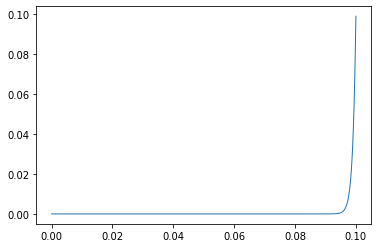

In [4]:
from numba import jit, cuda
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# to measure exec time 
from timeit import default_timer as timer

def drawgraph(xs, ys):
    plt.plot(xs, ys, linestyle='-', linewidth = 1)
    #plt.scatter(xs, ys, 2, "#0000FF", linestyle='-')
    
# function optimized to run on gpu  
@jit(target ="cuda")
def func(xs, ts, xxs, ys, E_x, E_y, n):
    # const
    x = 0.1; y = 0.1;
    dt = 0.0001
    
    def F1(x, y):
        #return x * (1 - E_x * x) - x * y
        return -x

    def F2(x, y):
        #return x * y * (1 - E_y * y) - y
        return -100*y
    
    for t in range(n):
        xs[t] = x 
        #-----------------------------------------------------
        k1_x = F1(x, y)
        k1_y = F2(x, y)
        k2_x = F1(x + dt / 2 * k1_x, y + dt / 2 * k1_y)
        k2_y = F2(x + dt / 2 * k1_x, y + dt / 2 * k1_y)
        k3_x = F1(x + dt / 2 * k2_x, y + dt / 2 * k2_y)
        k3_y = F2(x + dt / 2 * k2_x, y + dt / 2 * k2_y)
        k4_x = F1(x + dt * k3_x, y + dt * k3_y)
        k4_y = F2(x + dt * k3_x, y + dt * k3_y)
        #-----------------------------------------------------
        x += dt / 6 * (k1_x + 2 * k2_x + 2 * k3_x + k4_x)
        y += dt / 6 * (k1_y + 2 * k2_y + 2 * k3_y + k4_y)
        #-----------------------------------------------------
        '''
        if x > 20 or x < -10:
            break
        if y > 20 or y < -10:
            break
        '''
        xxs[t] = x
        ys[t] = y
        ts[t] = t

if __name__=="__main__":

    n = 100000
    
    #check
    
    xs = np.ones(n, dtype = np.float64)
    xxs = np.ones(n, dtype = np.float64)
    ys = np.ones(n, dtype = np.float64)
    ts = np.ones(n,  dtype = np.float64)
    zs = np.zeros(n,  dtype = np.float64)
    start = timer()
    
    #for e_x in range(-10, 1, 1):
    E_x = 0.0
    E_y = 0.0
    func(xs, ts, xxs, ys, E_x, E_y, n)
    drawgraph(xs, ys)
    data = pd.DataFrame({'x': xs, 'xx': xxs, 'y': ys, 't': ts, 'z': zs})
    data.to_csv('web/out.csv', index = False)
    
    print("with GPU:", timer()-start)
    plt.show()
